# Scoring

## Factor1_T-DTS

In [21]:
! pip install yfinance

In [22]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import pytz

# 1. รายชื่อหุ้น SET50 
SET50_TICKERS_BASE = [
    "ADVANC", "AOT", "AWC", "BANPU", "BBL", "BDMS", "BEM", "BGRIM", "BH", "BJC",
    "BPP", "CPALL", "CPF", "CPN", "CRC", "DELTA", "EGCO", "BSRC", "GULF", "HMPRO",
    "IRPC", "KBANK", "KTB", "KTC", "LH", "MINT", "MTC", "OR", "OSP",
    "PTT", "PTTEP", "PTTGC", "RATCH", "SAWAD", "SCB", "SCC", "SCGP", "TISCO", "TLI",
    "TOP", "TTB", "TU", "VGI", "WHA", "GLOBAL", "BAM", "CPAXT", "GPSC", "BLA"
]

SET50_TICKERS = [f"{ticker}.BK" for ticker in SET50_TICKERS_BASE]
set50_tickers = SET50_TICKERS

def analyze_tdts_history(tickers, start_year=2022, end_year=2026):
    all_data = []
    print(f"กำลังดึงข้อมูลย้อนหลังปี {start_year}-{end_year} ...")

    for symbol in tickers:
        try:
            # ดึงข้อมูลหุ้น
            stock = yf.Ticker(symbol)

            # 1. ดึงประวัติราคา (ย้อนหลังเผื่อไว้หน่อย)
            # ดึงตั้งแต่ต้นปี start_year ถึงปัจจุบัน
            history = stock.history(start=f"{start_year}-01-01", end=f"{end_year+1}-12-31")

            # 2. ดึงประวัติปันผล
            dividends = stock.dividends

            # แปลง timezone ให้ตรงกัน (เพื่อเทียบวันที่)
            if not history.empty:
                history.index = history.index.normalize() # ตัดเวลาออกเหลือแค่วันที่

            if not dividends.empty:
                 dividends.index = dividends.index.normalize()

            # กรองเอาเฉพาะปันผลในช่วงปีที่ต้องการ
            mask = (dividends.index.year >= start_year) & (dividends.index.year <= end_year)
            target_dividends = dividends.loc[mask]

            if target_dividends.empty:
                continue

            # 3. วนลูปคำนวณ T-DTS สำหรับการจ่ายปันผล "แต่ละครั้ง"
            for date, amount in target_dividends.items():
                # วันที่จ่ายปันผลใน yfinance คือ Ex-Date
                ex_date = date

                # ตรวจสอบว่ามีข้อมูลราคาในวัน Ex-Date หรือไม่
                if ex_date not in history.index:
                    continue

                # หา Index ของวัน Ex-Date
                loc_ex = history.index.get_loc(ex_date)

                # ถ้าเป็นวันแรกของข้อมูล จะไม่มี Cum Date (วันก่อนหน้า)
                if loc_ex == 0:
                    continue

                # วัน Cum Date คือวันทำการก่อนหน้า Ex-Date 1 วัน
                loc_cum = loc_ex - 1

                # ดึงข้อมูลราคาปิด (Close Price)
                p_ex = history.iloc[loc_ex]['Close']
                p_cum = history.iloc[loc_cum]['Close']
                date_cum = history.index[loc_cum]

                # --- คำนวณสูตร T-DTS ---
                # Dividend Yield (DY)
                dy = (amount / p_cum) * 100

                # Price Drop (PD)
                pd_pct = ((p_cum - p_ex) / p_cum) * 100

                # T-DTS
                if dy != 0:
                    t_dts = pd_pct / dy
                else:
                    t_dts = 0

                # เก็บข้อมูลลง List
                all_data.append({
                    'Stock': symbol.replace('', ''),
                    'Year': ex_date.year,
                    'Ex-Date': ex_date.strftime('%Y-%m-%d'),
                    'DPS (Baht)': amount,
                    'P_cum': p_cum,
                    'P_ex': p_ex,
                    'DY (%)': dy,
                    'PD (%)': pd_pct,
                    'T-DTS': t_dts
                })

        except Exception as e:
            print(f"Error checking {symbol}: {e}")

    # สร้าง DataFrame
    df = pd.DataFrame(all_data)

    # เรียงลำดับตาม ชื่อหุ้น -> ปี -> วันที่
    if not df.empty:
        df = df.sort_values(by=['Stock', 'Ex-Date'], ascending=[True, False])

    return df

# --- รันฟังก์ชัน ---
df_results_T_DTS = analyze_tdts_history(set50_tickers)
df_results_T_DTS

กำลังดึงข้อมูลย้อนหลังปี 2022-2026 ...


,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
7,ADVANC.BK,2025,2025-08-19,6.8900,287.110016,290.000000,2.399777,-1.006577,-0.419446
6,ADVANC.BK,2025,2025-02-20,5.7400,282.481110,276.367798,2.031994,2.164149,1.065037
5,ADVANC.BK,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563
4,ADVANC.BK,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146
3,ADVANC.BK,2023,2023-08-18,4.0000,201.021652,203.775375,1.989835,-1.369864,-0.688431
...,...,...,...,...,...,...,...,...,...
275,WHA.BK,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358194,-0.531779
274,WHA.BK,2023,2023-11-22,0.0669,4.474906,4.481165,1.495003,-0.139868,-0.093557
273,WHA.BK,2023,2023-05-11,0.1003,3.973449,3.973716,2.524256,-0.006738,-0.002669
272,WHA.BK,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186826,-0.090264


In [23]:
df_results_T_DTS[df_results_T_DTS['Stock'] == 'SCB.BK'][df_results_T_DTS['Year'] == 2023]

C:\Users\natta\AppData\Local\Temp\ipykernel_21808\3432150815.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_results_T_DTS[df_results_T_DTS['Stock'] == 'SCB.BK'][df_results_T_DTS['Year'] == 2023]


,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
210,SCB.BK,2023,2023-09-13,2.50,95.108742,95.527733,2.628570,-0.440539,-0.167596
209,SCB.BK,2023,2023-04-17,5.19,82.244469,83.220146,6.310455,-1.186314,-0.187992


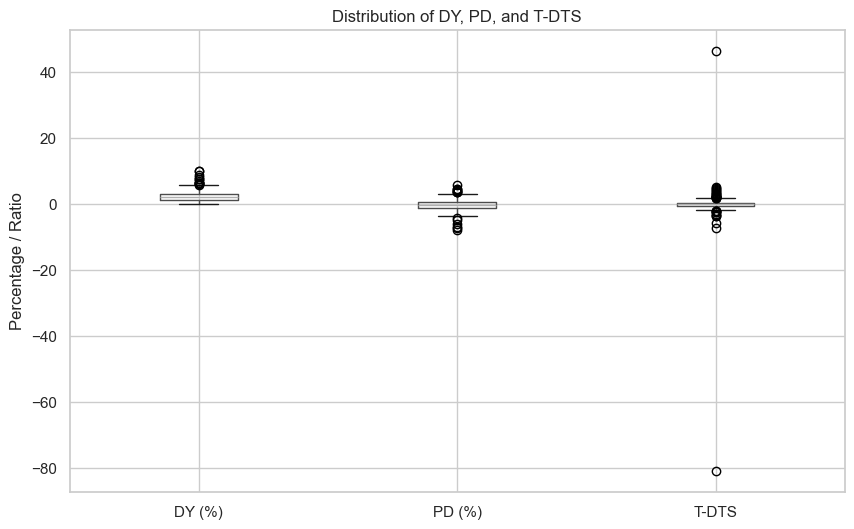

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# 2. สั่ง plot โดยไม่ต้องใส่ figsize ข้างใน
df_results_T_DTS[['DY (%)', 'PD (%)', 'T-DTS']].boxplot()

plt.title("Distribution of DY, PD, and T-DTS")
plt.ylabel("Percentage / Ratio")
plt.show()

In [25]:
# หาตัวการที่ทำให้กราฟเบี้ยว
outlier = df_results_T_DTS[(df_results_T_DTS['T-DTS'] < -10) | (df_results_T_DTS['T-DTS'] > 10)]
outlier

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
45,BGRIM.BK,2023,2023-03-14,0.035000,36.166218,34.543156,0.096775,4.487785,46.373204
205,SAWAD.BK,2024,2024-05-08,0.010455,33.019634,33.865894,0.031663,-2.562900,-80.943096


In [26]:
df_results_T_DTS_clean = df_results_T_DTS.drop(outlier.index)
df_results_T_DTS_clean

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS
7,ADVANC.BK,2025,2025-08-19,6.8900,287.110016,290.000000,2.399777,-1.006577,-0.419446
6,ADVANC.BK,2025,2025-02-20,5.7400,282.481110,276.367798,2.031994,2.164149,1.065037
5,ADVANC.BK,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563
4,ADVANC.BK,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146
3,ADVANC.BK,2023,2023-08-18,4.0000,201.021652,203.775375,1.989835,-1.369864,-0.688431
...,...,...,...,...,...,...,...,...,...
275,WHA.BK,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358194,-0.531779
274,WHA.BK,2023,2023-11-22,0.0669,4.474906,4.481165,1.495003,-0.139868,-0.093557
273,WHA.BK,2023,2023-05-11,0.1003,3.973449,3.973716,2.524256,-0.006738,-0.002669
272,WHA.BK,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186826,-0.090264


# Factor2_bf_af_avg


In [27]:
import yfinance as yf
import pandas as pd
from datetime import datetime

def calculate_tema(series, span):
    """ฟังก์ชันช่วยคำนวณ TEMA (Triple Exponential Moving Average)"""
    ema1 = series.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    ema3 = ema2.ewm(span=span, adjust=False).mean()
    return (3 * ema1) - (3 * ema2) + ema3

def analyze_xd_tema_history(tickers, start_year=2022, end_year=2024, window=15):
    all_data = []
    print(f"กำลังดึงข้อมูลและคำนวณ TEMA({window}) ย้อนหลังปี {start_year}-{end_year} ...")

    for symbol in tickers:
        try:
            stock = yf.Ticker(symbol)

            # 1. ดึงข้อมูลย้อนหลัง (เผื่อ Buffer ให้ TEMA ทำงานเสถียรหน่อย จึงลบ start_year ไปอีก 1 ปี)
            # เช่น อยากได้ 2022 ให้ดึงตั้งแต่ 2021
            fetch_start = f"{start_year - 1}-01-01" 
            history = stock.history(start=fetch_start, end=f"{end_year+1}-12-31")
            dividends = stock.dividends

            if history.empty:
                continue

            # 2. คำนวณ TEMA เตรียมไว้ใน DataFrame เลย
            history['TEMA'] = calculate_tema(history['Close'], span=window)

            # 3. จัดการ Timezone ให้ตรงกัน
            history.index = history.index.normalize()
            if not dividends.empty:
                dividends.index = dividends.index.normalize()

            # กรองเอาเฉพาะปันผลในช่วงปีที่ต้องการวิเคราะห์
            mask = (dividends.index.year >= start_year) & (dividends.index.year <= end_year)
            target_dividends = dividends.loc[mask]

            if target_dividends.empty:
                continue

            # 4. วนลูปวิเคราะห์เหตุการณ์ XD แต่ละครั้ง
            for date, amount in target_dividends.items():
                ex_date = date

                # ตรวจสอบว่ามีข้อมูลในวัน Ex-Date หรือไม่
                if ex_date not in history.index:
                    continue

                # หาตำแหน่ง Index ของวัน XD
                loc_xd = history.index.get_loc(ex_date)

                # --- Boundary Check ---
                # ตรวจสอบว่าข้อมูลมีเพียงพอสำหรับ Window หน้าและหลังหรือไม่
                # ต้องมีข้อมูลย้อนหลัง window วัน และมีข้อมูลล่วงหน้า window วัน
                if (loc_xd - window < 0) or (loc_xd + window >= len(history)):
                    continue

                # --- ดึงค่า TEMA ที่ตำแหน่งต่างๆ ---
                # loc_xd - window : จุดเริ่มต้นช่วงก่อน XD
                # loc_xd - 1      : วันทำการก่อน XD (Pre-XD)
                # loc_xd          : วัน XD
                # loc_xd + window : จุดสิ้นสุดช่วงหลัง XD
                
                tema_prev_win = history.iloc[loc_xd - window]['TEMA']
                tema_pre_xd   = history.iloc[loc_xd - 1]['TEMA']
                tema_xd       = history.iloc[loc_xd]['TEMA']
                tema_post_win = history.iloc[loc_xd + window]['TEMA']
                
                actual_price_xd = history.iloc[loc_xd]['Close']

                # --- คำนวณ Return โดยใช้ค่า TEMA ---
                # Ret_Bf: TEMA เปลี่ยนแปลงเท่าไหร่ในช่วง Window ก่อนถึงวัน XD
                ret_bf = ((tema_pre_xd - tema_prev_win) / tema_prev_win) * 100

                # Ret_Af: TEMA เปลี่ยนแปลงเท่าไหร่หลังจากวัน XD ไปจนจบ Window
                ret_af = ((tema_post_win - tema_xd) / tema_xd) * 100

                # เก็บข้อมูล
                all_data.append({
                    'Stock': symbol.replace('.BK', ''), # ตัด .BK ออกให้ดูสะอาดตา
                    'Year': ex_date.year,
                    'Ex-Date': ex_date.strftime('%Y-%m-%d'),
                    'DPS': amount,
                    'Price_Close': round(actual_price_xd, 2),
                    'Price_TEMA': round(tema_xd, 2),
                    'Ret_Bf_TEMA (%)': round(ret_bf, 2),
                    'Ret_Af_TEMA (%)': round(ret_af, 2)
                })

        except Exception as e:
            print(f"Error checking {symbol}: {e}")

    # สร้าง DataFrame และเรียงข้อมูล
    df = pd.DataFrame(all_data)
    
    if not df.empty:
        df = df.sort_values(by=['Stock', 'Ex-Date'], ascending=[True, False])

    return df

# --- รันฟังก์ชัน ---
# window=15 หมายถึง ดูย้อนหลัง 15 วัน และ ไปข้างหน้า 15 วัน (และใช้คำนวณ TEMA 15 ด้วย)
df_results_tema = analyze_xd_tema_history(set50_tickers, start_year=2022, end_year=2024, window=15)


# ตัวอย่างการดูเฉพาะหุ้น CPALL
df_results_tema[df_results_tema['Stock'] == 'BJC']

กำลังดึงข้อมูลและคำนวณ TEMA(15) ย้อนหลังปี 2022-2024 ...


,Stock,Year,Ex-Date,DPS,Price_Close,Price_TEMA,Ret_Bf_TEMA (%),Ret_Af_TEMA (%)
49,BJC,2024,2024-08-27,0.15,21.96,21.43,7.97,8.43
48,BJC,2024,2024-04-30,0.65,23.84,23.70,2.54,-9.35
47,BJC,2023,2023-08-24,0.15,33.23,33.09,1.65,-7.67
46,BJC,2023,2023-05-03,0.65,36.58,36.09,3.32,-3.73
45,BJC,2022,2022-08-24,0.15,30.94,31.16,4.35,1.45
44,BJC,2022,2022-04-28,0.51,31.25,30.85,-4.62,8.13


In [28]:
df_group = df_results_tema.groupby('Stock').aggregate({'DPS': 'mean', 'Ret_Af_TEMA (%)': 'mean', 'Ret_Bf_TEMA (%)': 'mean'})
df_group.head(10)

,DPS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%)
Stock,,,
ADVANC,4.235000,0.513333,3.273333
AOT,0.575000,1.945000,-6.145000
AWC,0.030920,-6.493333,-3.363333
BAM,0.493333,-8.546667,-3.083333
BANPU,0.346667,1.763333,2.845000
BBL,2.666667,1.655000,2.365000
BDMS,0.308333,2.578333,2.428333
BEM,0.113333,-1.746667,1.460000
BGRIM,0.145833,3.060000,-5.503333


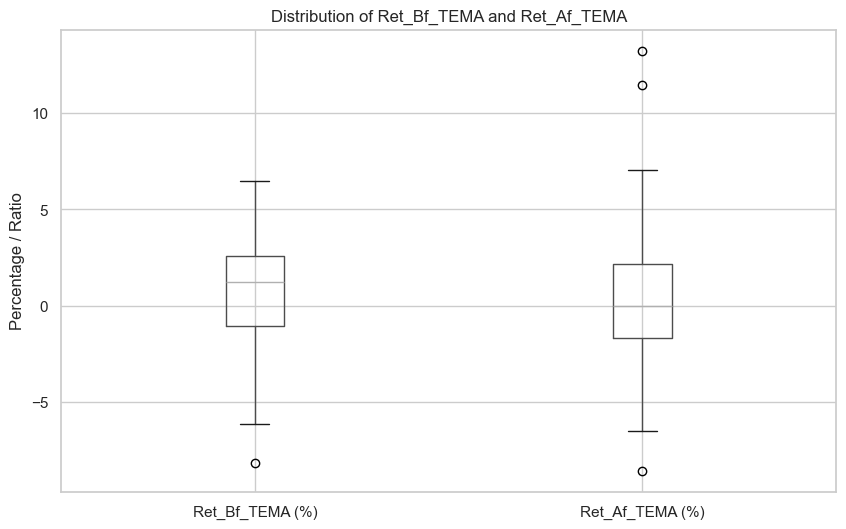

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# 2. สั่ง plot โดยไม่ต้องใส่ figsize ข้างใน
df_group[['Ret_Bf_TEMA (%)', 'Ret_Af_TEMA (%)']].boxplot()

plt.title("Distribution of Ret_Bf_TEMA and Ret_Af_TEMA")
plt.ylabel("Percentage / Ratio")
plt.show()

## Merge (TEMA + T-DTS)

In [30]:
import pandas as pd

# สมมติว่าคุณมี DataFrame 2 ตัวชื่อ df_tdts และ df_tema
df_tdts = df_results_T_DTS_clean
df_tema = df_results_tema

# --- ขั้นตอนที่ 1: จัด Format ชื่อหุ้นให้ตรงกัน ---
# ลบ .BK ออกจาก df_tdts เพื่อให้เหมือนกับ df_tema
df_tdts['Stock'] = df_tdts['Stock'].str.replace('.BK', '')

# --- ขั้นตอนที่ 2: แปลงวันที่ให้เป็น datetime object (เพื่อความชัวร์) ---
df_tdts['Ex-Date'] = pd.to_datetime(df_tdts['Ex-Date'])
df_tema['Ex-Date'] = pd.to_datetime(df_tema['Ex-Date'])

# --- ขั้นตอนที่ 3: เลือกเฉพาะคอลัมน์จาก TEMA ที่ต้องการมารวม ---
# เราไม่เอา Year หรือ DPS ซ้ำ เพราะใน T-DTS มีอยู่แล้ว
cols_to_use = ['Stock', 'Ex-Date', 'Price_TEMA', 'Ret_Bf_TEMA (%)', 'Ret_Af_TEMA (%)']
df_tema_subset = df_tema[cols_to_use]

# --- ขั้นตอนที่ 4: สั่ง Merge ---
# ใช้ key คือ 'Stock' และ 'Ex-Date' ตรงกัน
df_merged = pd.merge(
    df_tdts, 
    df_tema_subset, 
    on=['Stock', 'Ex-Date'], 
    how='inner'  # inner = เอาเฉพาะแถวที่ข้อมูลชนกันเจอทั้งคู่ (แนะนำ), left = ยึด T-DTS เป็นหลัก
)

# แสดงผล
df_merged

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS,Price_TEMA,Ret_Bf_TEMA (%),Ret_Af_TEMA (%)
0,ADVANC,2024,2024-08-19,4.8700,226.109360,230.772690,2.153825,-2.062422,-0.957563,231.77,9.00,9.26
1,ADVANC,2024,2024-02-19,4.6100,195.514221,196.086533,2.357885,-0.292721,-0.124146,194.93,-2.03,1.12
2,ADVANC,2023,2023-08-18,4.0000,201.021652,203.775375,1.989835,-1.369864,-0.688431,201.25,-0.51,-2.28
3,ADVANC,2023,2023-02-22,4.2400,185.480789,187.500015,2.285951,-1.088644,-0.476233,187.18,6.55,-1.22
4,ADVANC,2022,2022-08-19,3.4500,173.601196,173.115402,1.987313,0.279833,0.140810,173.75,-0.13,-2.34
...,...,...,...,...,...,...,...,...,...,...,...,...
217,WHA,2024,2024-05-09,0.1170,4.580949,4.643167,2.554056,-1.358194,-0.531779,4.65,5.82,8.65
218,WHA,2023,2023-11-22,0.0669,4.474906,4.481165,1.495003,-0.139868,-0.093557,4.45,-1.84,3.67
219,WHA,2023,2023-05-11,0.1003,3.973449,3.973716,2.524256,-0.006738,-0.002669,3.99,1.74,0.27
220,WHA,2022,2022-11-25,0.0669,3.232234,3.238273,2.069776,-0.186826,-0.090264,3.26,-3.20,4.90


In [31]:
df_merged[df_merged['Stock'] == 'BJC']

,Stock,Year,Ex-Date,DPS (Baht),P_cum,P_ex,DY (%),PD (%),T-DTS,Price_TEMA,Ret_Bf_TEMA (%),Ret_Af_TEMA (%)
46,BJC,2024,2024-08-27,0.15,21.916306,21.964685,0.684422,-0.220748,-0.322533,21.43,7.97,8.43
47,BJC,2024,2024-04-30,0.65,23.213980,23.838787,2.800037,-2.691513,-0.961242,23.70,2.54,-9.35
48,BJC,2023,2023-08-24,0.15,32.855274,33.229694,0.456548,-1.139604,-2.496134,33.09,1.65,-7.67
49,BJC,2023,2023-05-03,0.65,35.977688,36.583534,1.806675,-1.683950,-0.932071,36.09,3.32,-3.73
50,BJC,2022,2022-08-24,0.15,30.569580,30.936230,0.490684,-1.199394,-2.444331,31.16,4.35,1.45
51,BJC,2022,2022-04-28,0.51,30.560453,31.253969,1.668823,-2.269324,-1.359835,30.85,-4.62,8.13


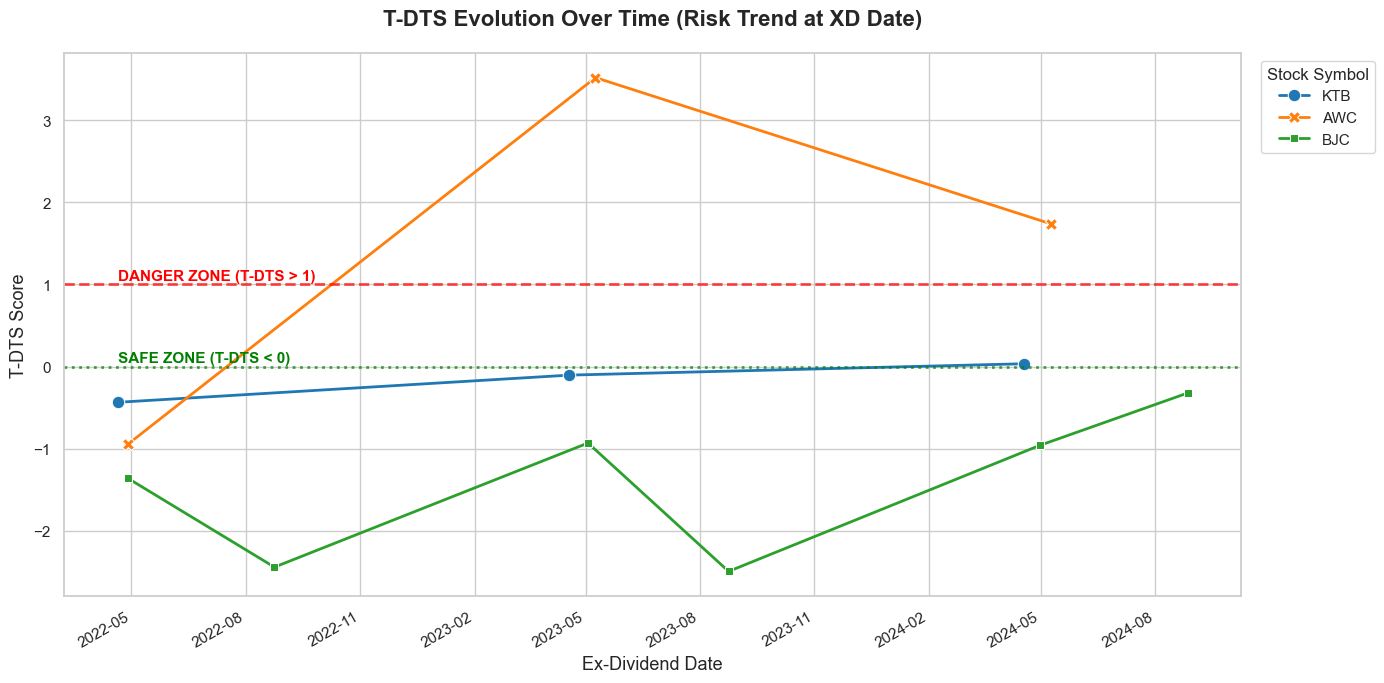

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

# --- 1. เตรียมข้อมูลจาก df_merged ---
# สมมติว่าคุณมี df_merged อยู่แล้วจากการรัน process_cluster_and_score
# แต่ถ้า column ชื่อ 'T_DTS' (มี underscore) หรือ 'T-DTS' (ขีดกลาง) ให้ปรับตรงนี้
target_col = 'T_DTS' if 'T_DTS' in df_merged.columns else 'T-DTS'

# แปลง Ex_Date เป็น datetime ให้ชัวร์
df_plot = df_merged.copy()
df_plot['Ex-Date'] = pd.to_datetime(df_plot['Ex-Date'])

# --- 2. เลือกหุ้นที่ต้องการดู (Filter) ---
# แนะนำให้เลือกดูทีละกลุ่ม เช่น Top 3 และ Bottom 3 จากการ Ranking
# คุณสามารถเปลี่ยนรายชื่อตรงนี้ได้ตามใจชอบ
selected_stocks = ['BJC', 'KTB', 'AWC']  
df_filtered = df_plot[df_plot['Stock'].isin(selected_stocks)].sort_values('Ex-Date')

# --- 3. สร้างกราฟ ---
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")

# สร้าง Line Chart + Markers (จุด XD)
# hue='Stock' จะแยกสีเส้นตามรายชื่อหุ้นให้อัตโนมัติ
sns.lineplot(
    data=df_filtered,
    x='Ex-Date', 
    y=target_col, 
    hue='Stock', 
    style='Stock',         # ใช้เส้นประ/เส้นทึบ ต่างกันเพื่อให้อ่านง่าย
    markers=True,          # แสดงจุด (Point) ตรงวัน XD
    dashes=False,          # (Optional) ถ้าอยากได้เส้นทึบหมดให้แก้เป็น True
    linewidth=2,
    palette="tab10",       # ชุดสีที่ตัดกันชัดเจน
    markersize=9
)

# --- 4. เพิ่มเส้น Reference Zone ---
# เส้น T-DTS = 1 (Dividend Trap Zone)
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.text(df_filtered['Ex-Date'].min(), 1.05, 'DANGER ZONE (T-DTS > 1)', 
         color='red', fontsize=11, fontweight='bold')

# เส้น T-DTS = 0 (Safe Zone)
plt.axhline(y=0, color='green', linestyle=':', linewidth=2, alpha=0.7)
plt.text(df_filtered['Ex-Date'].min(), 0.05, 'SAFE ZONE (T-DTS < 0)', 
         color='green', fontsize=11, fontweight='bold')

# --- 5. ตกแต่งกราฟ ---
plt.title('T-DTS Evolution Over Time (Risk Trend at XD Date)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Ex-Dividend Date', fontsize=13)
plt.ylabel('T-DTS Score', fontsize=13)
plt.legend(title='Stock Symbol', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=11)

# จัด Format แกนวันที่
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # โชว์ทุก 3 เดือน
plt.gcf().autofmt_xdate() # เอียงวันที่ให้อ่านง่าย

plt.tight_layout()
plt.show()

In [33]:
df_agg = df_merged.groupby('Stock').aggregate({'DY (%)': 'mean', 'T-DTS': 'mean', 'Ret_Af_TEMA (%)': 'mean', 'Ret_Bf_TEMA (%)': 'mean'})
df_agg.head(10)

,DY (%),T-DTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%)
Stock,,,,
ADVANC,2.141122,-0.427355,0.513333,3.273333
AOT,0.965508,-0.667021,1.945000,-6.145000
AWC,0.680557,1.436622,-6.493333,-3.363333
BAM,4.049142,0.272654,-8.546667,-3.083333
BANPU,4.399007,-0.247804,1.763333,2.845000
BBL,2.072059,-0.492392,1.655000,2.365000
BDMS,1.185160,-1.316282,2.578333,2.428333
BEM,1.384812,-0.166353,-1.746667,1.460000
BGRIM,0.607163,-0.014762,1.982000,-5.078000


d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

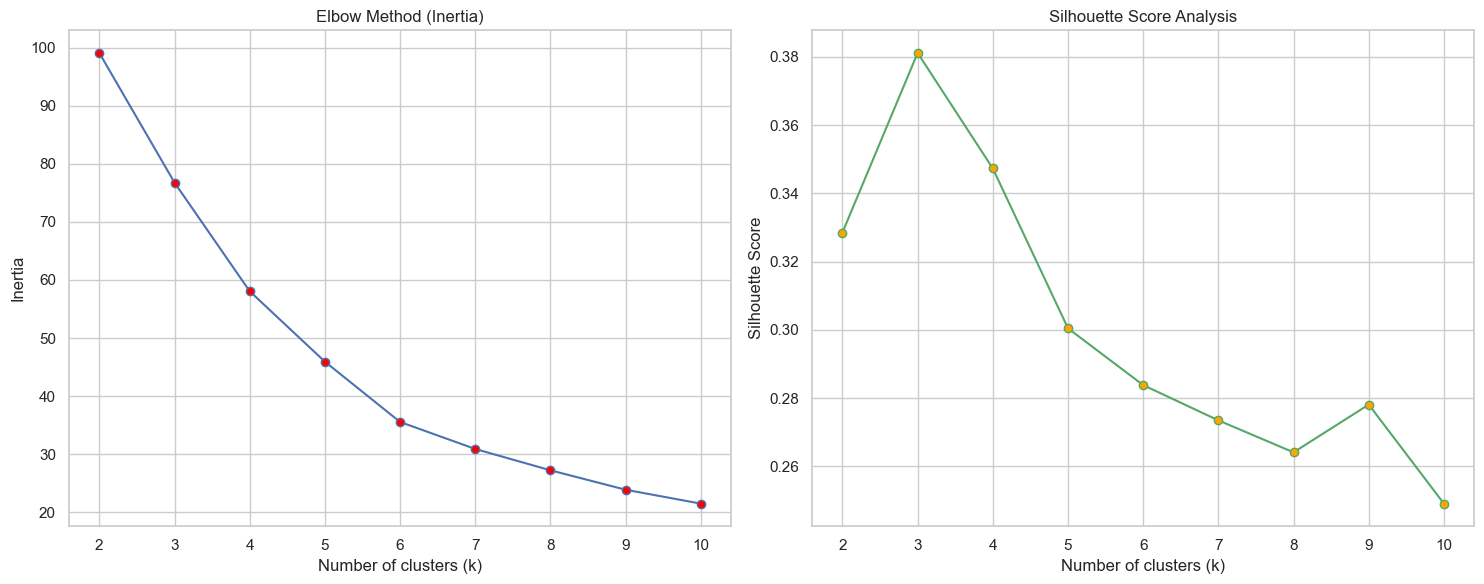

    k    Inertia  Silhouette Score
0   2  99.063079          0.328567
1   3  76.752826          0.381186
2   4  58.056588          0.347334
3   5  45.938943          0.300489
4   6  35.558385          0.283846
5   7  30.910913          0.273515
6   8  27.240551          0.264146
7   9  23.896642          0.278139
8  10  21.503539          0.249111


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. เตรียมข้อมูล (Clean & Scale)
# ลบแถวที่มี NaN (ถ้ามี) เพื่อไม่ให้ error
df_clustering = df_agg.dropna().copy()

# กำหนด Features ที่จะใช้
features = ['T-DTS', 'Ret_Af_TEMA (%)', 'Ret_Bf_TEMA (%)']
X = df_clustering[features]

# Standardize ข้อมูล (ปรับสเกลให้ mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. คำนวณ Inertia และ Silhouette Score สำหรับ k ต่างๆ
inertia_values = []
silhouette_scores = []
k_range = range(2, 11)  # ลองแบ่งกลุ่มตั้งแต่ 2 ถึง 10 กลุ่ม

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # เก็บค่า Inertia (Sum of squared distances of samples to their closest cluster center)
    inertia_values.append(kmeans.inertia_)
    
    # เก็บค่า Silhouette Score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 3. พล็อตกราฟแสดงผล
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# กราฟ Elbow Method (Inertia)
ax1.plot(k_range, inertia_values, 'bo-', markerfacecolor='red')
ax1.set_title('Elbow Method (Inertia)')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.grid(True)

# กราฟ Silhouette Score
ax2.plot(k_range, silhouette_scores, 'go-', markerfacecolor='orange')
ax2.set_title('Silhouette Score Analysis')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

# แสดงค่า Score แบบตารางเพื่อให้ดูง่าย
df_scores = pd.DataFrame({
    'k': k_range,
    'Inertia': inertia_values,
    'Silhouette Score': silhouette_scores
})
print(df_scores)

d:\Users\natta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


=== K-Means Clustering (k=4) Results ===
Inertia: 58.06
Silhouette Score: 0.3473

=== Cluster Summary ===
   Cluster     T-DTS  Ret_Af_TEMA (%)  Ret_Bf_TEMA (%)  Count
0        0 -0.351635        -0.361299         2.160644     29
1        1  1.255708        -4.226000        -1.323833      5
2        2 -0.338291        10.575000         3.981667      3
3        3 -0.245314         1.080057        -3.510098     10


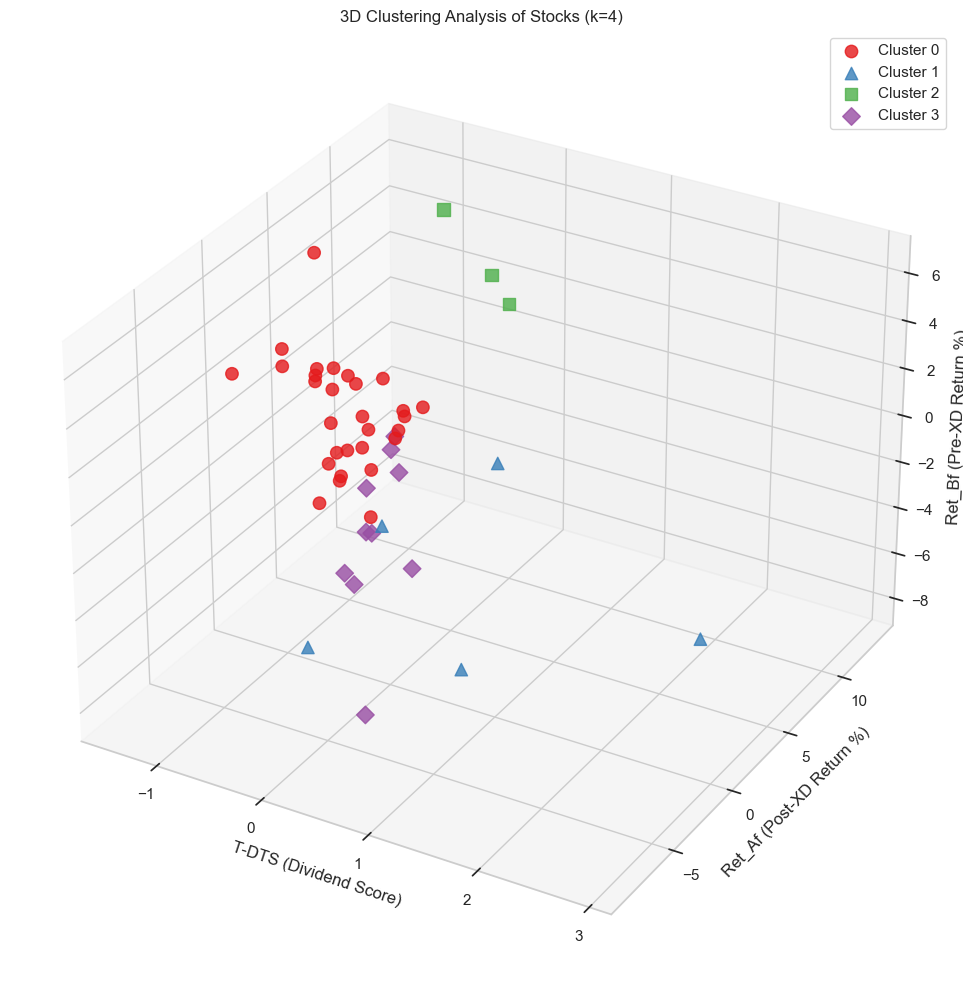

--------------------------------------------------

Cluster 0 (29 stocks):
ADVANC, BANPU, BBL, BDMS, BEM, BH, BJC, BPP, CPALL, CPF, EGCO, HMPRO, KBANK, KTC, LH

Cluster 1 (5 stocks):
AWC, BAM, DELTA, GPSC, IRPC

Cluster 2 (3 stocks):
BSRC, GLOBAL, KTB

Cluster 3 (10 stocks):
AOT, BGRIM, BLA, CPN, CRC, MTC, OSP, SCC, VGI, WHA


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # จำเป็นสำหรับ 3D Plot
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. เตรียมข้อมูล (Clean & Scale)
# ใช้ df_agg ที่คุณ aggregate มาแล้ว
df_model = df_agg.dropna().copy()
features = ['T-DTS', 'Ret_Af_TEMA (%)', 'Ret_Bf_TEMA (%)']

# Standardize ข้อมูล (ปรับสเกลให้เป็นมาตรฐานเดียวกัน)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])

# 2. สร้างโมเดล K-Means (k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_model['Cluster'] = kmeans.fit_predict(X_scaled)

# คำนวณ Score เพื่อดูคุณภาพ
inertia = kmeans.inertia_
sil_score = silhouette_score(X_scaled, df_model['Cluster'])

print(f"=== K-Means Clustering (k={k}) Results ===")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {sil_score:.4f}")

# ดูค่าเฉลี่ยของแต่ละกลุ่ม (Centroids)
cluster_summary = df_model.groupby('Cluster')[features].mean().reset_index()
cluster_summary['Count'] = df_model.groupby('Cluster')['T-DTS'].count().values
print("\n=== Cluster Summary ===")
print(cluster_summary)

# 3. สร้างกราฟ 3D Scatter Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# กำหนดสีสำหรับ 4 กลุ่ม
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # Red, Blue, Green, Purple
markers = ['o', '^', 's', 'D']

for cluster_id in range(k):
    subset = df_model[df_model['Cluster'] == cluster_id]
    ax.scatter(
        subset['T-DTS'], 
        subset['Ret_Af_TEMA (%)'], 
        subset['Ret_Bf_TEMA (%)'], 
        c=colors[cluster_id],
        marker=markers[cluster_id],
        s=80,      # ขนาดจุด
        alpha=0.8, # ความโปร่งใส
        label=f'Cluster {cluster_id}'
    )

# ตั้งชื่อแกน
ax.set_xlabel('T-DTS (Dividend Score)')
ax.set_ylabel('Ret_Af (Post-XD Return %)')
ax.set_zlabel('Ret_Bf (Pre-XD Return %)')
ax.set_title(f'3D Clustering Analysis of Stocks (k={k})')

# มุมมอง (สามารถปรับหมุนได้ถ้าทำใน Notebook Interactive)
# ax.view_init(elev=20, azim=45) 

plt.legend()
plt.tight_layout()
plt.show()

# 4. (แถม) แสดงรายชื่อหุ้นในแต่ละกลุ่ม
print("-" * 50)
for i in range(k):
    stocks = df_model[df_model['Cluster'] == i].index.tolist()
    print(f"\nCluster {i} ({len(stocks)} stocks):")
    print(", ".join(stocks[:15])) # โชว์แค่ 15 ตัวแรก

In [36]:
df_model
df_scoring = df_model.copy()
df_scoring['Total_Score (%)'] = (df_scoring['DY (%)'] * (1 - df_scoring['T-DTS']))\
      + df_scoring['Ret_Af_TEMA (%)']
#df scoring without cluster column
df_scoring_without_cluster = df_scoring.drop(columns=['Cluster'])
df_scoring_without_cluster.sort_values(by='Total_Score (%)', ascending=False).head(10)

,DY (%),T-DTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%),Total_Score (%)
Stock,,,,,
BSRC,1.930389,-1.010215,13.225000,4.415000,17.105495
KTB,4.808630,-0.168987,11.443333,2.050000,17.064559
GLOBAL,1.285110,0.164327,7.056667,5.480000,8.130598
TLI,4.984354,-0.613519,-0.483333,3.476667,7.559019
TISCO,6.294302,-0.203381,-0.242000,2.174000,7.332441
BANPU,4.399007,-0.247804,1.763333,2.845000,7.252432
SCB,4.201017,-0.583883,0.396000,1.138000,7.049920
PTTEP,3.368735,-0.195429,2.906667,1.061667,6.933750
MTC,1.380495,-0.725995,4.280000,-3.556667,6.662727


In [37]:
# สร้าง Dictionary สำหรับ map ชื่อกลุ่มตามที่วิเคราะห์
cluster_names = {
    0: 'Rebound Star (Buy on Dip)',     # ลงก่อน XD -> เด้งหลัง XD (คุ้ม)
    1: 'Golden Goose (Strong Trend)',   # ขึ้นตลอดทาง (คุ้มที่สุด)
    2: 'Sell on Fact (Neutral)',        # เสมอตัว -> เริ่มไหลลง (ขายทำกำไร)
    3: 'Dividend Trap (Avoid)'          # ลงตลอดทาง (ขาดทุนยับ)
}

# เพิ่มชื่อกลุ่มลงในตารางสรุป (cluster_summary)
df_scoring['Cluster_Name'] = df_scoring['Cluster'].map(cluster_names)


df_scoring

,DY (%),T-DTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%),Cluster,Total_Score (%),Cluster_Name
Stock,,,,,,,
ADVANC,2.141122,-0.427355,0.513333,3.273333,0,3.569475,Rebound Star (Buy on Dip)
AOT,0.965508,-0.667021,1.945000,-6.145000,3,3.554522,Dividend Trap (Avoid)
AWC,0.680557,1.436622,-6.493333,-3.363333,1,-6.790479,Golden Goose (Strong Trend)
BAM,4.049142,0.272654,-8.546667,-3.083333,1,-5.601541,Golden Goose (Strong Trend)
BANPU,4.399007,-0.247804,1.763333,2.845000,0,7.252432,Rebound Star (Buy on Dip)
BBL,2.072059,-0.492392,1.655000,2.365000,0,4.747324,Rebound Star (Buy on Dip)
BDMS,1.185160,-1.316282,2.578333,2.428333,0,5.323498,Rebound Star (Buy on Dip)
BEM,1.384812,-0.166353,-1.746667,1.460000,0,-0.131487,Rebound Star (Buy on Dip)
BGRIM,0.607163,-0.014762,1.982000,-5.078000,3,2.598126,Dividend Trap (Avoid)


In [38]:
cluster_summary

,Cluster,T-DTS,Ret_Af_TEMA (%),Ret_Bf_TEMA (%),Count
0,0,-0.351635,-0.361299,2.160644,29
1,1,1.255708,-4.226000,-1.323833,5
2,2,-0.338291,10.575000,3.981667,3
3,3,-0.245314,1.080057,-3.510098,10
